# Machine Learning Nanodegree
## Capstone Project: Electric Vehicle Detection 

# Introduction

### Setup

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display, Image 
from sklearn.cluster import KMeans

# Pretty display for notebooks
%matplotlib inline

## Data Clean Up

### Import

In [2]:
ev_train_raw = pd.read_csv('EV_train.csv')
ev_train_labels_raw = pd.read_csv('EV_train_labels.csv')

In [3]:
print(ev_train_raw.shape)
print(ev_train_labels_raw.shape)
display(ev_train_raw.head())
display(ev_train_labels_raw.head())
print(ev_train_raw.isnull().values.any())  # Null values in training dataset?
print(ev_train_labels_raw.isnull().values.any())  #Null values in training labels?

(1590, 2881)
(1590, 2881)


,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
0,11655099,0.950,0.826,0.361,0.238,0.342,0.233000,0.351000,0.194000,0.292000,...,0.664,0.783,0.601,0.639,0.417,0.439,0.226,0.190,0.710,0.728
1,11633257,0.353,0.327,0.358,0.292,0.285,0.304000,0.361000,0.342000,0.355000,...,0.536,0.558,0.622,0.634,0.513,0.421,0.273,0.296,0.291,0.289
2,11651552,0.150,0.181,0.150,0.150,0.131,0.125000,0.088000,0.106000,0.094000,...,2.125,0.881,0.481,1.194,0.138,0.119,0.038,0.088,0.056,0.113
3,11636092,2.088,2.075,2.121,2.098,2.046,2.081000,1.847000,0.420000,0.399000,...,0.620,0.487,0.563,0.419,0.379,0.359,0.347,0.325,0.330,0.340
4,11647239,1.416,1.250,1.270,1.258,1.239,1.753105,4.609256,4.619256,4.075151,...,1.596,1.667,1.569,1.664,1.580,1.635,1.568,1.565,1.575,1.571


,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
0,11655099,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11633257,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11651552,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11636092,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11647239,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


True
False


### Quantify Missign Values

In [4]:
# Missing value frequency by interval
ev_train_raw.isnull().sum(axis=0)[ev_train_raw.isnull().sum(axis=0)>0].value_counts()

1    288
4     48
3     48
2     48
dtype: int64

In [5]:
# Missing value frequency by house
ev_train_raw.isnull().sum(axis=1)[ev_train_raw.isnull().sum(axis=1)>0].value_counts()

432    1
48     1
144    1
96     1
dtype: int64

### Add Temporal Dimensions

In [6]:
ev_train_pivot = ev_train_raw.copy()
ev_train_pivot = pd.wide_to_long(ev_train_pivot, stubnames='Interval_', i='House ID', j='kWh').reset_index()
ev_train_pivot.columns = ['House ID', 'Interval', 'kWh']
ev_train_pivot['Interval'] = pd.to_numeric(ev_train_pivot['Interval'], downcast='integer')
ev_train_pivot = ev_train_pivot.sort_values(['House ID', 'Interval']).reset_index(drop=True)

In [7]:
ev_train_labels_pivot = ev_train_labels_raw.copy()
ev_train_labels_pivot = pd.wide_to_long(ev_train_labels_pivot, stubnames='Interval_', i='House ID', j='label').reset_index()
ev_train_labels_pivot.columns = ['House ID', 'Interval', 'Label']
ev_train_labels_pivot['Interval'] = pd.to_numeric(ev_train_labels_pivot['Interval'], downcast='integer')
ev_train_labels_pivot = ev_train_labels_pivot.sort_values(['House ID', 'Interval']).reset_index(drop=True)

In [8]:
ev_train_pivot_label = pd.concat([ev_train_pivot, ev_train_labels_pivot['Label']], axis=1)

In [9]:
##Checking Label Concatenation (pd.merge was failing due to memory limits?)

import random

display(ev_train_pivot_label[ev_train_pivot_label['House ID']==11647239].head(9))

all_raw_house_ids  = ev_train_raw['House ID'].unique()

random_house_id = random.choice(all_raw_house_ids)
random_interval = random.randint(1,2880)


lcr1 = ev_train_pivot_label['House ID']==random_house_id
lcc1 = ev_train_pivot_label['Interval']==random_interval
display(ev_train_pivot_label[lcr1&lcc1])

lcr2 = ev_train_raw.index[ev_train_raw['House ID']==random_house_id].values[0]
raw_kwh = ev_train_raw.iloc[lcr2,random_interval]
raw_label = ev_train_labels_raw.iloc[lcr2,random_interval]

rand_dict = {
    "House ID": random_house_id,
    "Interval": random_interval,
    "kWh": raw_kwh,
    "Label": raw_label 
}
print(rand_dict)


,House ID,Interval,kWh,Label
3173760,11647239,1,1.416000,0
3173761,11647239,2,1.250000,0
3173762,11647239,3,1.270000,0
3173763,11647239,4,1.258000,0
3173764,11647239,5,1.239000,0
3173765,11647239,6,1.753105,1
3173766,11647239,7,4.609256,1
3173767,11647239,8,4.619256,1
3173768,11647239,9,4.075151,1


,House ID,Interval,kWh,Label
3839626,11651081,587,0.59,0


{'House ID': 11651081, 'Interval': 587, 'kWh': 0.58999999999999997, 'Label': 0}


In [10]:
ev_train_raw.iloc[lcr2,random_interval-1:random_interval+1]

Interval_586    0.603
Interval_587    0.590
Name: 1153, dtype: float64

In [11]:
print(ev_train_pivot.shape)
print(2*24*60*1590)

temp_dim_dict = {
    "Day": np.tile(np.repeat(np.arange(1,61),48),1590),
    "Hour": np.tile(np.tile(np.repeat(np.arange(1,25),2),60),1590),
    "Half Hour": np.tile(np.tile(np.arange(1,49),60),1590)
}

temp_dim_df = pd.DataFrame.from_dict(temp_dim_dict)

(4579200, 3)
4579200


In [12]:
ev_train_piv_lab_tmp = pd.concat([ev_train_pivot_label, temp_dim_df], axis=1)
ev_train_piv_lab_tmp_cols = ['House ID','Day','Hour','Half Hour','Interval', 'kWh', 'Label']
ev_train_piv_lab_tmp = ev_train_piv_lab_tmp[ev_train_piv_lab_tmp_cols] 
ev_train_piv_lab_tmp.head()

,House ID,Day,Hour,Half Hour,Interval,kWh,Label
0,11628280,1,1,1,1,1.114,0
1,11628280,1,1,2,2,0.845,0
2,11628280,1,2,3,3,0.463,0
3,11628280,1,2,4,4,0.453,0
4,11628280,1,3,5,5,0.610,0


In [13]:
# Checking Temporal Concatenation (pd.merge was failing due to memory limits?)

check_aggs =['max', 'min','mean','count']

check_dict = {
    'Day' : check_aggs, 
    'Hour': check_aggs,
    'Half Hour': check_aggs,
}

temp_merge_check_df = ev_train_piv_lab_tmp.groupby('House ID').agg(check_dict)

unique_records = len(temp_merge_check_df.drop_duplicates())
total_records = len(temp_merge_check_df)

assert unique_records == 1, "Problem with temporal concatenation"

display(temp_merge_check_df.head())

Day                 Hour                 Half Hour                
         max min  mean count  max min  mean count       max min  mean count
House ID                                                                   
11628280  60   1  30.5  2880   24   1  12.5  2880        48   1  24.5  2880
11628291  60   1  30.5  2880   24   1  12.5  2880        48   1  24.5  2880
11628301  60   1  30.5  2880   24   1  12.5  2880        48   1  24.5  2880
11628319  60   1  30.5  2880   24   1  12.5  2880        48   1  24.5  2880
11628335  60   1  30.5  2880   24   1  12.5  2880        48   1  24.5  2880

In [14]:
display(ev_train_piv_lab_tmp.iloc[45:50,])
display(ev_train_piv_lab_tmp[ev_train_piv_lab_tmp['House ID']==11647239].head(9))

,House ID,Day,Hour,Half Hour,Interval,kWh,Label
45,11628280,1,23,46,46,1.146,0
46,11628280,1,24,47,47,1.130,0
47,11628280,1,24,48,48,1.170,0
48,11628280,2,1,1,49,1.239,0
49,11628280,2,1,2,50,0.952,0


,House ID,Day,Hour,Half Hour,Interval,kWh,Label
3173760,11647239,1,1,1,1,1.416000,0
3173761,11647239,1,1,2,2,1.250000,0
3173762,11647239,1,2,3,3,1.270000,0
3173763,11647239,1,2,4,4,1.258000,0
3173764,11647239,1,3,5,5,1.239000,0
3173765,11647239,1,3,6,6,1.753105,1
3173766,11647239,1,4,7,7,4.609256,1
3173767,11647239,1,4,8,8,4.619256,1
3173768,11647239,1,5,9,9,4.075151,1


### Fill in Missing Values

In [15]:
all_missing_rows = ev_train_piv_lab_tmp['kWh'].isnull()
display(ev_train_piv_lab_tmp[all_missing_rows].head())

,House ID,Day,Hour,Half Hour,Interval,kWh,Label
757296,11632700,58,1,1,2737,NaN,0
757297,11632700,58,1,2,2738,NaN,0
757298,11632700,58,2,3,2739,NaN,0
757299,11632700,58,2,4,2740,NaN,0
757300,11632700,58,3,5,2741,NaN,0


In [16]:
house_hh_mean_df = ev_train_piv_lab_tmp.groupby(['House ID','Half Hour']).agg({'kWh':'mean'}).reset_index()

In [17]:
house_hh_mean_df.head()

,House ID,Half Hour,kWh
0,11628280,1,1.034950
1,11628280,2,0.990733
2,11628280,3,0.904383
3,11628280,4,0.940583
4,11628280,5,0.958350


In [18]:
ev_train_piv_lab_tmp_filled = ev_train_piv_lab_tmp.copy()

for idx, row in ev_train_piv_lab_tmp_filled[all_missing_rows].iterrows():

    missing_interval = row['Interval']
    missing_house = row['House ID']
    missing_half_hour = row['Half Hour']
    
    house_rm = house_hh_mean_df['House ID'] == missing_house
    half_hour_rm = house_hh_mean_df['Half Hour'] == missing_half_hour
    house_half_hour_average = house_hh_mean_df[house_rm&half_hour_rm]['kWh'].values[0]
    
    house_rf = ev_train_piv_lab_tmp_filled['House ID'] == missing_house
    interval_rf = ev_train_piv_lab_tmp_filled['Interval'] == missing_interval
    ev_train_piv_lab_tmp_filled['kWh'][house_rf&interval_rf] = house_half_hour_average

/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [19]:
display(ev_train_piv_lab_tmp.iloc[757292:757299,:])
display(ev_train_piv_lab_tmp_filled.iloc[757292:757299,:])

,House ID,Day,Hour,Half Hour,Interval,kWh,Label
757292,11632700,57,23,45,2733,1.812128,1
757293,11632700,57,23,46,2734,1.787128,1
757294,11632700,57,24,47,2735,1.242252,1
757295,11632700,57,24,48,2736,0.125000,0
757296,11632700,58,1,1,2737,NaN,0
757297,11632700,58,1,2,2738,NaN,0
757298,11632700,58,2,3,2739,NaN,0


,House ID,Day,Hour,Half Hour,Interval,kWh,Label
757292,11632700,57,23,45,2733,1.812128,1
757293,11632700,57,23,46,2734,1.787128,1
757294,11632700,57,24,47,2735,1.242252,1
757295,11632700,57,24,48,2736,0.125000,0
757296,11632700,58,1,1,2737,0.405968,0
757297,11632700,58,1,2,2738,0.413420,0
757298,11632700,58,2,3,2739,0.433921,0


## Validation Split

In [20]:
from sklearn.model_selection import train_test_split

all_raw_house_ids

h_train, h_test = train_test_split(all_raw_house_ids, test_size=0.25, random_state=42)

print("Trainig Houses:{0}, Validation Houses:{1}, Total Houses:{2}".format(
    len(h_train), 
    len(h_test), 
    len(h_train)+len(h_test))
     )

Trainig Houses:1192, Validation Houses:398, Total Houses:1590


In [26]:
X_train_records = ev_train_piv_lab_tmp_filled['House ID'].isin(h_train)

#training
X_train = ev_train_piv_lab_tmp_filled[X_train_records]
y_train = X_train['Label']
X_train.drop(['Label'], axis=1, inplace=True)
display(X_train.head())
display(y_train.head())

#validation
X_test = ev_train_piv_lab_tmp_filled[~X_train_records]
y_test = X_test['Label']
X_test.drop(['Label'], axis=1, inplace=True)
display(X_test.head())
display(y_test.head())

print(X_train.shape)
print(len(h_train)*2880)

print(X_test.shape)
print(len(h_test)*2880)



/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,House ID,Day,Hour,Half Hour,Interval,kWh
0,11628280,1,1,1,1,1.114
1,11628280,1,1,2,2,0.845
2,11628280,1,2,3,3,0.463
3,11628280,1,2,4,4,0.453
4,11628280,1,3,5,5,0.610


0    0
1    0
2    0
3    0
4    0
Name: Label, dtype: int64

/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,House ID,Day,Hour,Half Hour,Interval,kWh
8640,11628319,1,1,1,1,0.712
8641,11628319,1,1,2,2,0.763
8642,11628319,1,2,3,3,0.709
8643,11628319,1,2,4,4,0.771
8644,11628319,1,3,5,5,0.729


8640    0
8641    0
8642    0
8643    0
8644    0
Name: Label, dtype: int64

(3432960, 6)
3432960
(1146240, 6)
1146240


## Feature Engineering

In [27]:
Image(url= "http://aprs.org/Energy/Charging/L1-EV-timed-charging.GIF")

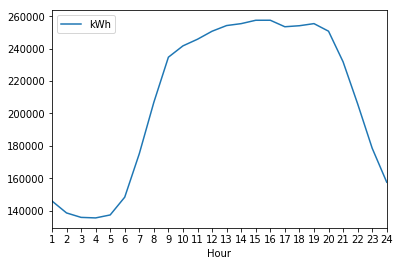

In [28]:
X_train.groupby('Hour').agg({'kWh':'sum'}).plot(xticks=np.arange(1,25))

In [29]:
#X_train.head()
X_train_load_curve = X_train.pivot_table(values='kWh', 
                                         index=['House ID', 'Day'], 
                                         columns='Half Hour')
X_train_load_curve.head()

Half Hour        1      2      3      4      5      6      7      8      9   \
House ID Day                                                                  
11628280 1    1.114  0.845  0.463  0.453  0.610  0.558  0.608  0.481  0.517   
         2    1.239  0.952  0.694  0.497  0.552  0.499  0.523  0.505  0.526   
         3    1.227  0.879  0.515  0.589  0.654  0.590  0.585  0.824  0.792   
         4    1.254  1.054  0.550  0.443  0.493  0.478  0.494  0.529  0.545   
         5    1.157  0.911  0.483  0.508  0.479  0.500  0.492  0.463  0.404   

Half Hour        10  ...       39     40     41     42     43     44     45  \
House ID Day         ...                                                      
11628280 1    0.565  ...    0.598  0.649  0.713  0.717  1.153  1.274  1.166   
         2    0.444  ...    0.880  0.796  1.015  0.764  1.225  1.414  1.269   
         3    0.814  ...    0.774  0.681  0.634  0.577  1.147  1.190  1.176   
         4    0.569  ...    0.415  0.461  0.584  0.598  1.117  1.185  1.179   
         5    0.394  ...    0.639  0.528  0.491  0.848  1.177  1.290  1.244   

Half Hour        46     47     48  
House ID Day                       
11628280 1    1.146  1.130  1.170  
         2    1.290  1.269  1.250  
         3    1.614  2.191  1.378  
         4    1.247  1.256  1.158  
         5    1.301  1.318  1.309  

[5 rows x 48 columns]

In [30]:
kmeans = KMeans(n_clusters=2, random_state=42).fit(X_train_load_curve.as_matrix())

In [33]:
kmeans.labels_

71520